# CS4320 - Introduction to Machine Learning 

## Homework 5: Evaluation metrics

**Please type your name and A number here:**

In [119]:
Name = "Carter Watson"
assert Name != "", 'Please enter your name in the above quotation marks, thanks!'

A_number = "A02312565"
assert A_number != "", 'Please enter your A-number in the above quotation marks, thanks!'

credit = "https://chat.openai.com/share/a19dbd4d-dcbc-4923-ab29-c2dadbb0b4fe"
assert credit != "", 'Please enter your link to chatgpt conversation in the above quotation marks, thanks!'

## Imports

In [120]:
import os
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn import datasets
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    mean_absolute_percentage_error
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import PrecisionRecallDisplay

## Exercise 1: Precision, recall, and f1 score by hand <a name="1"></a>
<hr>

rubric={points:12}

Consider the problem of predicting whether a patient has a disease or not. Below are confusion matrices of two machine learning models: Model A and Model B.

- Model A confusion matrix

In [121]:
cm_A = pd.DataFrame(
    [[3, 10],
     [1, 106]],
    columns=["Predicted disease", "Predicted no disease"],
    index=["Actual disease", "Actual no disease"])

cm_A

,Predicted disease,Predicted no disease
Actual disease,3,10
Actual no disease,1,106


- Model B confusion matrix

In [122]:
cm_B = pd.DataFrame(
    [[8, 5],
     [12, 95]],
    columns=["Predicted disease", "Predicted no disease"],
    index=["Actual disease", "Actual no disease"])

cm_B

,Predicted disease,Predicted no disease
Actual disease,8,5
Actual no disease,12,95


### 1.1 Positive vs. negative class 
rubric={points:1}

**Your tasks:**

Precision, recall, and f1 score depend upon which class is considered "positive", that is the thing you wish to find. In the example above, which class is likely to be the "positive" class? Why? 

Type your answer here: The positive class is likely "disease." This is likely because disease is what we're hoping to identify.

### 1.2 Accuracy
rubric={points:2}

**Your tasks:**

Calculate accuracies for Model A and Model B. 

We'll store all metrics associated with Model A and Model B in the `results_dict` below. 

In [123]:
results_dict = {"A": {}, "B": {}}

In [124]:
results_dict["A"]["accuracy"] = (cm_A.loc["Actual disease", "Predicted disease"] + cm_A.loc["Actual no disease", "Predicted no disease"]) / cm_A.values.sum()
results_dict["B"]["accuracy"] = (cm_B.loc["Actual disease", "Predicted disease"] + cm_B.loc["Actual no disease", "Predicted no disease"]) / cm_B.values.sum()

In [125]:
pd.DataFrame(results_dict)

,A,B
accuracy,0.908333,0.858333


### 1.3 Which model would you pick? 
rubric={points:1}

**Your tasks:**

Which model would you pick simply based on the accuracy metric? 

Type your answer here: I would pick A because it's more accurate here.

### 1.4 Precision, recall, f1-score
rubric={points:6}

**Your tasks:**

1. Calculate precision, recall, f1-score for Model A and Model B manually, without calling `scikit-learn` functions.

In [126]:
results_dict["A"]["precision"] = (cm_A.loc["Actual disease", "Predicted disease"]) / (cm_A.loc["Actual disease", "Predicted disease"] + cm_A.loc["Actual no disease", "Predicted disease"])
results_dict["B"]["precision"] = (cm_B.loc["Actual disease", "Predicted disease"]) / (cm_B.loc["Actual disease", "Predicted disease"] + cm_B.loc["Actual no disease", "Predicted disease"])
results_dict["A"]["recall"] = cm_A.loc["Actual disease", "Predicted disease"] / (cm_A.loc["Actual disease", "Predicted disease"] + cm_A.loc["Actual disease", "Predicted no disease"])
results_dict["B"]["recall"] = cm_B.loc["Actual disease", "Predicted disease"] / (cm_B.loc["Actual disease", "Predicted disease"] + cm_B.loc["Actual disease", "Predicted no disease"])
results_dict["A"]["f1"] = 2 * (results_dict["A"]["precision"] * results_dict["A"]["recall"]) / (results_dict["A"]["precision"] + results_dict["A"]["recall"])
results_dict["B"]["f1"] = 2 * (results_dict["B"]["precision"] * results_dict["B"]["recall"]) / (results_dict["B"]["precision"] + results_dict["B"]["recall"])

pd.DataFrame(results_dict)

,A,B
accuracy,0.908333,0.858333
precision,0.750000,0.400000
recall,0.230769,0.615385
f1,0.352941,0.484848


### 1.5 Discussion
rubric={points:2}

**Your tasks:**
1. Which metric is more informative in this problem? Why? 
2. Which model would you pick based on this information? 

Type your answer here:

1. Recall is the most important metric here.  This is because the cost of a false negative can literally be life and death.

2. Based on this information model B would be better as it's recall is significantly higher

### Exercise 2: Classification evaluation metrics using `sklearn` <a name="2"></a>
<hr>
rubric={points:48}

In general, when a dataset is imbalanced, accuracy does not provide the whole story. In class, we looked at credit card fraud dataset which is a classic example of an imbalanced dataset. 

Another example is customer churn datasets. [Customer churn](https://en.wikipedia.org/wiki/Customer_attrition) refers to the notion of customers leaving a subscription service like Netflix. In this exercise, we will try to predict customer churn in a dataset where most of the customers stay with the service and a small minority cancel their subscription. To start, please download the [Kaggle telecom customer churn dataset](https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). Once you have the data, you should be able to run the following code:

The starter code below reads the data CSV as a pandas dataframe and splits it into 70% train and 30% test. 

Note that `churn` column in the dataset is the target. "True" means the customer left the subscription (churned) and "False" means they stayed.

> Note that for this kind of problem a more appropriate technique is something called survival analysis. For now, we'll just treat it as a binary classification problem. 

In [127]:
df = pd.read_csv("bigml_59c28831336c6604c800002a.csv", encoding="utf-8")
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
1402,NE,70,415,421-8535,no,no,0,213.4,86,36.28,...,77,17.40,256.6,101,11.55,5.7,4,1.54,1,False
1855,WI,67,510,417-2265,no,no,0,109.1,134,18.55,...,76,12.10,91.2,86,4.10,10.9,5,2.94,2,False
633,NJ,122,415,327-9341,no,yes,34,146.4,104,24.89,...,103,7.62,220.0,91,9.90,15.6,4,4.21,2,False
1483,NV,107,510,419-9688,yes,no,0,234.1,91,39.80,...,105,13.86,282.5,100,12.71,10.0,3,2.70,1,False
2638,HI,105,510,364-8128,no,no,0,125.4,116,21.32,...,95,22.23,241.6,104,10.87,11.4,9,3.08,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,WY,126,408,339-9798,yes,no,0,197.6,126,33.59,...,112,20.95,285.3,104,12.84,12.5,8,3.38,2,False
3089,WV,70,510,348-3777,no,yes,30,143.4,72,24.38,...,92,14.45,127.9,68,5.76,9.4,4,2.54,3,False
1766,NJ,125,415,406-6400,no,no,0,182.3,64,30.99,...,121,11.88,171.6,96,7.72,11.6,7,3.13,2,False
1122,NE,159,415,362-5111,no,no,0,189.1,105,32.15,...,147,20.92,242.0,106,10.89,10.4,5,2.81,1,True


### 2.1 Distribution of target values
rubric={points:2}

**Your tasks:**

Examine the distribution of target values in the train split.(Print out the count of each class) Do you see class imbalance? If yes, do we need to deal with it? Why or why not? 

In [128]:
train_df["churn"].value_counts()

churn
False    1984
True      349
Name: count, dtype: int64

Type your answer here:  
Yes there is class imbalance, there are far more cases of false then of true.  
Yes we need to deal with class imblance.  
Without dealing with imbalance the model could predict false most of the time and score well. This is simply because false is more common, not because the model is accurate.

### 2.2 Column transformer 
rubric={points:12}

The code below creates `X_train`, `y_train`, `X_test`, `y_test` for you. 
In preparation for building a classifier, set up a `ColumnTransformer` that performs whatever feature transformations you deem sensible. This can include dropping features if you think they are not helpful. Remember that by default `ColumnTransformer` will drop any columns that aren't accounted for when it's created.

You can create a column transformer in two ways:
- by using [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
- by using [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) 


In each case, briefly explain your rationale with 1-2 sentences. You do not need an explanation for every feature, but for every group of features that are being transformed the same way. For example, "I am doing transformation X to the following categorical features: `a`, `b`, `c` because of reason Y," etc.

In [129]:
X_train = train_df.drop(columns=["churn"])
X_test = test_df.drop(columns=["churn"])

y_train = train_df["churn"]
y_test = test_df["churn"]

In [130]:
# all information around usage is numerical in nature, it will undergo standard scaling to normalize the data
numerical_cols = ['account length', 'number vmail messages', 'customer service calls',
                  'total day minutes', 'total day calls', 'total day charge',
                  'total eve minutes', 'total eve calls', 'total eve charge',
                  'total night minutes', 'total night calls', 'total night charge',
                  'total intl minutes', 'total intl calls', 'total intl charge', ]

# all information that is categorical will be one hot encoded to allow for the model to understand the data in an appropriate way
categorical_cols = ['state']

# all information that is boolean will be one hot encoded and translated from yes/no to boolean values
boolean = ['international plan', 'voice mail plan']
for category in boolean:
    X_train[category] = X_train[category].replace({'Yes': 1, 'No': 0})
categorical_cols += boolean

# phone number shouldn't have an effect on churn, so it will be dropped
# area code also shouldn't have an effect
drop = ['phone number', 'area code']

# Define transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

Briefly explain your rationale: explained in comments

### 2.3 Visualizing the transformed data 
rubric={points:1}

Fit and transform your `ColumnTransformer` on your training set. Print the first 5 rows of the transformed data as a dataframe (not numpy array). See lecture for code that can get you the new column names after transforming. 

In [131]:
transformed_data = preprocessor.fit_transform(X_train)

# Get feature names for one-hot encoded columns
new_categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

# Combine with feature names for numerical data
new_feature_names = np.concatenate([numerical_cols, new_categorical_features], axis=0)

# If it's a sparse matrix, convert to a dense format
if isinstance(transformed_data, sp.sparse.csr_matrix):
    transformed_data = transformed_data.toarray()

transformed_df = pd.DataFrame(transformed_data, columns=new_feature_names)

transformed_df.head(5)

,account length,number vmail messages,customer service calls,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,international plan_no,international plan_yes,voice mail plan_no,voice mail plan_yes
0,-0.767893,-0.587624,-0.415269,0.618769,-0.721211,0.618927,0.069871,-1.156734,0.069926,1.088667,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-0.843585,-0.587624,0.337507,-1.293778,1.655252,-1.293517,-1.167277,-1.207278,-1.166291,-2.162302,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.544113,1.900976,0.337507,-0.609809,0.169963,-0.609654,-2.210130,0.157417,-2.211244,0.369287,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.165650,-0.587624,-0.415269,0.998345,-0.473663,0.998611,-0.754894,0.258506,-0.755774,1.597736,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.115188,-0.587624,0.337507,-0.994886,0.764078,-0.994731,1.195994,-0.246937,1.196515,0.793839,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### 2.4 Area code feature
rubric={points:1}

The original dataset had a feature called `area code`. Let's assume we encoded this feature with one-hot encoding.

1. The area codes were numbers to begin with. Why do we want to use one-hot encoding on this feature?

Type your answer here: We want to one-hot encoding this feature because leaving the area codes as is could cause any of the following problems...

- ordinality confusion: some models may assume there is ordinality where there is none
- numerical relationship: some models may create a numerical relationship where there isn't a relationship

### 2.5 Dummy classifier
rubric={points:4}

**Your tasks:**

Create a `DummyClassifier`. Report the following scoring metrics via cross-validation: accuracy, precision, recall, f1-score. Briefly comment on your results, including any *warnings* the code produces (2 sentences max).

In [132]:
# Create a DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")

# Define scoring metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1_score': make_scorer(f1_score, zero_division=0)
}

# Apply cross-validation
cv_results = cross_validate(dummy_clf, transformed_data, y_train, cv=5, scoring=scoring_metrics)

# Print results
for metric in cv_results:
    if 'test_' in metric:
        print(f"{metric}: {cv_results[metric].mean()}")

print("The dummyclassifier is the worst model, as it is just guessing the most frequent class, which is no churn.")

test_accuracy: 0.8504075874681789
test_precision: 0.0
test_recall: 0.0
test_f1_score: 0.0
The dummyclassifier is the worst model, as it is just guessing the most frequent class, which is no churn.


### 2.6 Logistic regression
rubric={points:4} 

**Your tasks:**

1. Create a `LogisticRegression`. 
2. Report the same metrics as in the previous part.

In [133]:
# Create a LogisticRegression classifier
logistic_clf = LogisticRegression()

# Define scoring metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1_score': make_scorer(f1_score, zero_division=0)
}

# Apply cross-validation
cv_results = cross_validate(logistic_clf, transformed_data, y_train, cv=5, scoring=scoring_metrics)

# Print results
for metric in cv_results:
    if 'test_' in metric:
        print(f"{metric}: {cv_results[metric].mean()}")

print("The logistic regression model is the more model than dummy classifier, as it has a higher accuracy, precision, recall, and f1 score.")

test_accuracy: 0.8564097379860491
test_precision: 0.5517670268020899
test_recall: 0.21217391304347824
test_f1_score: 0.30594457267476
The logistic regression model is the more model than dummy classifier, as it has a higher accuracy, precision, recall, and f1 score.


### 2.7 Logistic regression with `class_weight`
rubric={points:2}

**Your tasks:**

1. Set the `class_weight` parameter of your logistic regression model to `'balanced'` and report the same metrics as in the previous part. 
2. Do you prefer this model to the one in the previous part? Discuss your results in a few sentences.

In [134]:
logistic_clf = LogisticRegression(class_weight='balanced')

# Define scoring metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1_score': make_scorer(f1_score, zero_division=0)
}

# Apply cross-validation
cv_results = cross_validate(logistic_clf, transformed_data, y_train, cv=5, scoring=scoring_metrics)

# Print results
for metric in cv_results:
    if 'test_' in metric:
        print(f"{metric}: {cv_results[metric].mean()}")

print("The logistic regression model with balanced class weight has worse accuracy and precision, but significantly better recall and f1 score.")

test_accuracy: 0.7586641056510832
test_precision: 0.3486353987029868
test_recall: 0.6992132505175983
test_f1_score: 0.46473024428190435
The logistic regression model with balanced class weight has worse accuracy and precision, but significantly better recall and f1 score.


### 2.8 Hyperparameter optimization
rubric={points:6}

Now let's tune the hyperparameters of our `LogisticRegression` using `GridSearchCV` to maximize cross-validation f1 score. 

**Your tasks:**

1. Jointly optimize `C` (choose some reasonable values) and `class_weight` (`None` vs. `'balanced'`) with `GridSearchCV` and `scoring="f1"`. 
2. What values of `C` and `class_weight` are chosen ? (Print out best "C" and best "class_weight")

In [135]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Example values for C
    'class_weight': [None, 'balanced']
}

# Set up GridSearchCV
grid_search = GridSearchCV(logistic_clf, param_grid, cv=5, scoring='f1')

# Fit GridSearchCV
grid_search.fit(transformed_data, y_train)

# Retrieve and print the best parameters
best_params = grid_search.best_params_
print("Best C:", best_params['C'])
print("Best class_weight:", best_params['class_weight'])


/home/cwatson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cwatson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

Best C: 0.1
Best class_weight: balanced


/home/cwatson/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 2.9 Test results
rubric={points:16}

**Your tasks**
1. Evaluate the best model on the test set. In particular show each of the following on the test set:  
    - Confusion matrix. 
    - Classification report. 
    - Precision-recall curve with average precision score.     
    - ROC curve with AUC. 

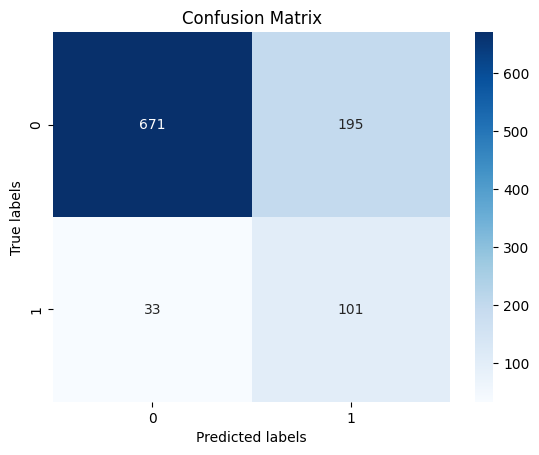

              precision    recall  f1-score   support

       False       0.95      0.77      0.85       866
        True       0.34      0.75      0.47       134

    accuracy                           0.77      1000
   macro avg       0.65      0.76      0.66      1000
weighted avg       0.87      0.77      0.80      1000



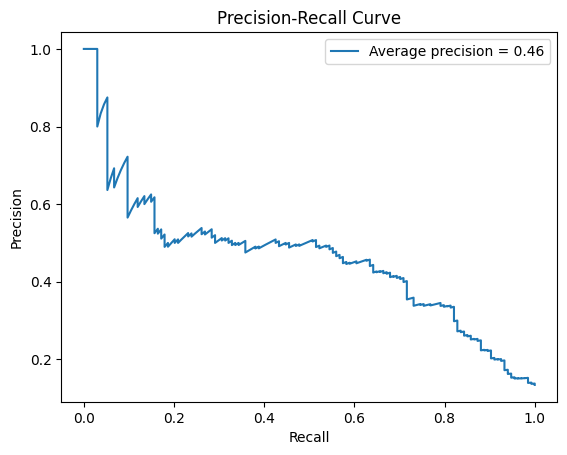

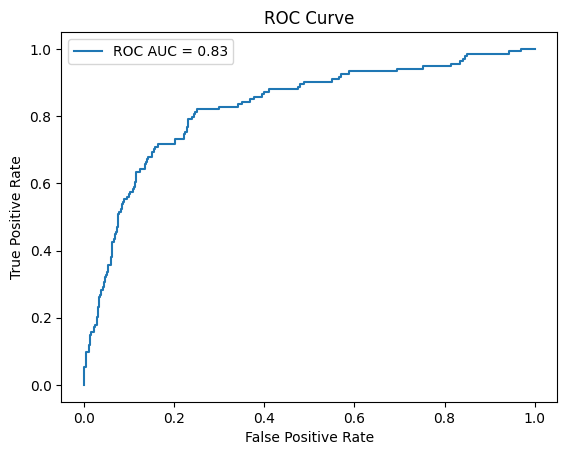

In [136]:
# Predict on test set
X_test_transformed = preprocessor.transform(X_test)
y_pred = grid_search.best_estimator_.predict(X_test_transformed)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# print classification report
report = classification_report(y_test, y_pred)
print(report)

# Predict probabilities
y_scores = grid_search.best_estimator_.predict_proba(X_test_transformed)[:, 1]

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Calculate average precision score
average_precision = average_precision_score(y_test, y_scores)

# Plot precision-recall curve
plt.plot(recall, precision, label=f'Average precision = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)

# Calculate AUC
roc_auc = roc_auc_score(y_test, y_scores)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Exercise 3: Regression metrics <a name="3"></a>
<hr> 


rubric={points=40}

For this exercise, we'll use [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) from `sklearn datasets`. The code below loads the dataset.  

In [137]:
from sklearn.datasets import fetch_california_housing

housing_df = fetch_california_housing(as_frame=True).frame

### 3.1: Data spitting and exploration 
rubric={points:10}

**Your tasks:**

1. Split the data into train (80%) and test (20%) splits. 
2. Explore the train split. Do you need to apply any transformations on the data? If yes, create a preprocessor with the appropriate transformations. 
3. Separate `X` and `y` in train and test splits. 

In [138]:
# split data into just train and test sets
X = housing_df.drop(columns=['MedHouseVal'])
y = housing_df['MedHouseVal']

# create a preprocessor
numerical_cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
geographical_cols = ['Latitude', 'Longitude']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with the median
    ('scaler', StandardScaler())                    # Scale data
])

geographical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))   # Impute missing values with the median
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('geo', geographical_transformer, geographical_cols)
    ])

# apply the preprocessor to the data
transformed_data = preprocessor.fit_transform(X)

# split train and test into x and y splits
X_train, X_test, y_train, y_test = train_test_split(transformed_data, y, test_size=0.2, random_state=42)

### 3.2 Baseline: DummyRegressor 
rubric={points:2}

**Your tasks:**
1. Carry out cross-validation using `DummyRegressor` with default scoring. 

In [139]:
# create dummy regressor
dummy_regr = DummyRegressor(strategy="mean")

# Define scoring metrics
scoring_metrics = {
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'r2': 'r2'
}

# Apply cross-validation
cv_results = cross_validate(dummy_regr, X_train, y_train, cv=5, scoring=scoring_metrics)

# Print results
for metric in cv_results:
    if 'test_' in metric:
        print(f"{metric}: {cv_results[metric].mean()}")

test_neg_mean_squared_error: -1.3369296823892636
test_neg_mean_absolute_error: -0.9139467450818867
test_r2: -0.00031742988315350826


### 3.3 Different regressors
rubric={points:8}

In this exercise, we are going to use [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model which we haven't looked into yet. At this point you should feel comfortable using models with our usual ML workflow even if you don't know the details. We'll talk about `RandomForestRegressor` later in the course.  

The code below defines a custom scorer called `mape_scorer` and creates dictionaries for different regressors (`models`) and different scoring metrics (`score_types_reg`). 

**Your tasks:**

1. Using the `models` and the evaluation metrics `score_types_reg` in the code below, carry out cross-validation with each model, by passing the evaluation metrics to `scoring` argument of `cross_validate`. Use a pipeline with the model as an estimator if you are applying any transformations. 
2. Show results as a dataframe. 
3. Interpret the results. Which model seems to be performing well with different metrics? 


In [140]:
def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

models = {
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
}

score_types_reg = {
    "neg_mean_squared_error": "neg_mean_squared_error",
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "r2": "r2",
    "mape_scorer": mape_scorer,
}

In [141]:
results = {}

# Loop through models
for model_name, model in models.items():
    # If transformations are needed, create a pipeline (assuming 'preprocessor' is your transformation pipeline)
    # pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    # cv_results = cross_validate(pipeline, X_train, y_train, scoring=score_types_reg, cv=5)

    # If no transformations, directly use the model
    cv_results = cross_validate(model, X_train, y_train, scoring=score_types_reg, cv=5)

    # Store results
    results[model_name] = cv_results

# Convert results to DataFrame for easy comparison
df_results = pd.DataFrame(results).T.map(np.mean)

# Display results
print(df_results)

               fit_time  score_time  test_neg_mean_squared_error  \
Ridge          0.005987    0.005481                    -0.519263   
Random Forest  9.488183    0.081892                    -0.261659   

               test_neg_root_mean_squared_error  test_neg_mean_absolute_error  \
Ridge                                 -0.720526                     -0.529071   
Random Forest                         -0.511495                     -0.334652   

                test_r2  test_mape_scorer  
Ridge          0.611486        -31.529803  
Random Forest  0.804136        -18.707837  


Type your answer here: Overall the random forest model outperforms the ridge model in almost every category.  That being said it takes hugely longer to train and to score.  This results in a tradeoff where performance time must be traded for accuracy

### 3.4 Hyperparameter optimization 
rubric={points:8}

**Your tasks:**
1. Carry out hyperparameter optimization using `RandomizedSearchCV` and `Ridge` with the following `param_dist`. The `alpha` hyperparameter of `Ridge` controls the fundamental tradeoff. Choose the metric of your choice for hyperparameter optimization. 

In [142]:
from scipy.stats import loguniform

param_dist = {"alpha": loguniform(1e-3, 1e3)}

In [143]:
# Create a Ridge model instance
ridge = Ridge()

scoring_metric = "neg_mean_squared_error"

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=ridge, 
    param_distributions=param_dist, 
    n_iter=100,  # Number of parameter settings that are sampled
    scoring=scoring_metric, 
    cv=5,  # 5-fold cross-validation
    random_state=42
)

# Fit RandomizedSearchCV to the data
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'alpha': 24.658329458549105}
Best score: -0.5192350624925857


### 3.5 Test results
rubric={points:6}

**Your tasks:**

1. Try the best model on the test set and use mape metric to evaluate your results.
2. Briefly comment on the results. (1 to 2 sentences) 

In [144]:
# Use the best model to make predictions on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate MAPE
mape_score = mean_absolute_percentage_error(y_test, y_pred)

# Print the MAPE score
print(f"MAPE on the test set: {mape_score * 100:.2f}%")

print("Because the MAPE score is above 20\% it indicates that this model may have some serious issues predicting the data.")


MAPE on the test set: 31.96%
Because the MAPE score is above 20\% it indicates that this model may have some serious issues predicting the data.


### 3.6 Model interpretation  
rubric={points:6}

Ridge is a linear model and it learns coefficients associated with each feature during `fit()`. 

**Your tasks:**

1. Visualize coefficients learned by the `Ridge` model above as a pandas dataframe with two columns: features and coefficients. Use the `Ridge` model with best hyperparameters. Sort the coefficients in descending order. 
2. Increasing which feature values would result in higher housing price? 

In [145]:
ridge_coefficients = best_model.coef_

# Create a DataFrame with feature names and coefficients
coeff_df = pd.DataFrame({
    'Feature': preprocessor.get_feature_names_out(),
    'Coefficient': ridge_coefficients
})

# Sort the DataFrame by coefficients in descending order
sorted_coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)

# Display the sorted DataFrame
print(sorted_coeff_df)

# Interpretation
print("\nFeatures that increase housing price when their values go up:")
print(sorted_coeff_df[sorted_coeff_df['Coefficient'] > 0])

           Feature  Coefficient
0      num__MedInc     0.847059
3   num__AveBedrms     0.360574
1    num__HouseAge     0.122512
4  num__Population    -0.002229
5    num__AveOccup    -0.036490
2    num__AveRooms    -0.294436
6    geo__Latitude    -0.419458
7   geo__Longitude    -0.433029

Features that increase housing price when their values go up:
          Feature  Coefficient
0     num__MedInc     0.847059
3  num__AveBedrms     0.360574
1   num__HouseAge     0.122512
